# 4x CO2

In [2]:
pip install netcdf4


   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ----------------------------------- ---- 6.3/7.0 MB 128.3 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 26.9 MB/s eta 0:00:00


In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from netCDF4 import num2date
from matplotlib.colors import LinearSegmentedColormap
import imageio
import os
import matplotlib

In [2]:
# File Paths 
files = {
    "ta": "ta_Amon_abrupt-4xCO2_1850-2014.nc",
    "hus": "specific_humidity_abrupt-4xCO2_1850-2014.nc",
    "zg": "zg_Amon_abrupt-4xCO2_1850-2014.nc",
    "toa_sw_down": "toa_incoming_shortwave_flux_abrupt-4xCO2_1850-2014.nc",  # rsdt
    "toa_sw_up": "toa_outgoing_shortwave_flux_abrupt-4xCO2_1850-2014.nc",  # rsut
    "surf_sw_down": "surface_downwelling_shortwave_flux_in_air_abrupt-4xCO2_1850-2014.nc",  # rsds
    "surf_sw_up": "surface_upwelling_shortwave_flux_in_air_abrupt-4xCO2_1850-2017.nc",  # rsus
    "toa_lw_up": "toa_outgoing_longwave_flux_abrupt-4xCO2_1850-2014.nc",  # rlut
    "surf_lw_up": "surface_upwelling_longwave_flux_in_air_abrupt-4xCO2_1850-2014.nc",  # rlus
    "surf_lw_down": "surface_downwelling_longwave_flux_in_air_abrupt-4xCO2_1850-2014.nc",  # rlds
    "sensible": "surface_upward_sensible_heat_flux_abrupt-4xCO2_1850-2014.nc",  # hfss
    "latent": "surface_upward_latent_heat_flux_abrupt-4xCO2_1850-2014.nc"  # hfls
}

In [3]:
def load_nc_variable(filename, var_name, year):
    """Loads a variable from NetCDF file for a specific year."""
    ds = nc.Dataset(filename, mode="r")
    time_var = ds.variables["time"]
    time_units = time_var.units
    time_values = num2date(time_var[:], units=time_units)
    year_indices = [i for i, t in enumerate(time_values) if t.year == year]
    
    if not year_indices:
        raise ValueError(f"No data found for year {year}")
    
    var = ds.variables[var_name][year_indices, ...] if var_name in ds.variables else None
    if var is None:
        raise ValueError(f"Variable {var_name} not found in {filename}")
        
    ds.close()
    return var

In [4]:
def compute_storage_term(T, q, pressure_levels):
    """Computes the vertically integrated atmospheric storage term."""
    cp = 1005  # J/kgK
    Lv = 2.5e6  # J/kg
    g = 9.81  # m/s²
    
    # not moist static energy
    dse = cp * T + Lv * q
    
    # Time derivative (assuming monthly data)
    dt = 30 * 24 * 3600  # seconds in a month (approximate)
    storage_term = np.gradient(dse, dt, axis=0)
    
    # Vertical integration (pressure integral)
    dp = -np.gradient(pressure_levels)  # Negative because pressure decreases with height
    storage_term_integrated = np.trapz(storage_term / g, x=pressure_levels, axis=1)
    
    return storage_term_integrated

In [5]:
def calculate_aht(year_to_analyze):
    """Main function to calculate atmospheric heat transport."""
    # Load required variables
    toa_sw_down = load_nc_variable(files["toa_sw_down"], "rsdt", year_to_analyze)
    toa_sw_up = load_nc_variable(files["toa_sw_up"], "rsut", year_to_analyze)  # rsut
    surf_sw_down = load_nc_variable(files["surf_sw_down"], "rsds", year_to_analyze)  # rsds
    surf_sw_up = load_nc_variable(files["surf_sw_up"], "rsus", year_to_analyze)  # rsus
    toa_lw_up = load_nc_variable(files["toa_lw_up"], "rlut", year_to_analyze)  # rlut
    surf_lw_up = load_nc_variable(files["surf_lw_up"], "rlus", year_to_analyze)  # rlus
    surf_lw_down = load_nc_variable(files["surf_lw_down"], "rlds", year_to_analyze)  # rlds
    sensible = load_nc_variable(files["sensible"], "hfss", year_to_analyze)  # hfss
    latent = load_nc_variable(files["latent"], "hfls", year_to_analyze)  # hfls
    
    # Energy components
    sw_absorbed = (toa_sw_down - toa_sw_up) - (surf_sw_down - surf_sw_up)
    shf = sensible + latent + (surf_lw_up - surf_lw_down)
    
    # Storage term
    T = load_nc_variable(files["ta"], "ta", year_to_analyze)
    q = load_nc_variable(files["hus"], "hus", year_to_analyze)
    
    with nc.Dataset(files["ta"], mode="r") as ds_atm:
        pressure_levels = ds_atm.variables["plev"][:]
        
    storage_term = compute_storage_term(T, q, pressure_levels)
    
    # Final AHT calculation
    aht = sw_absorbed - toa_lw_up + shf - storage_term
    
    return aht

In [6]:
def compute_meridional_transport(aht, latitudes):
    """Computes meridional heat transport"""
    R_earth = 6.371e6  # Earth radius in meters
    lat_radians = np.deg2rad(latitudes)
    dlat = np.gradient(lat_radians)
    cos_lat = np.cos(lat_radians)
    
    # Zonal and time mean
    aht_zonal_mean = np.mean(aht, axis=(0, -1))
    
    # Meridional integration from South to North
    transport = 2 * np.pi * R_earth**2 * np.cumsum(aht_zonal_mean * cos_lat * dlat)
    
    # Convert to Petawatts
    transport_PW = transport * 1e-15
    
    return transport_PW

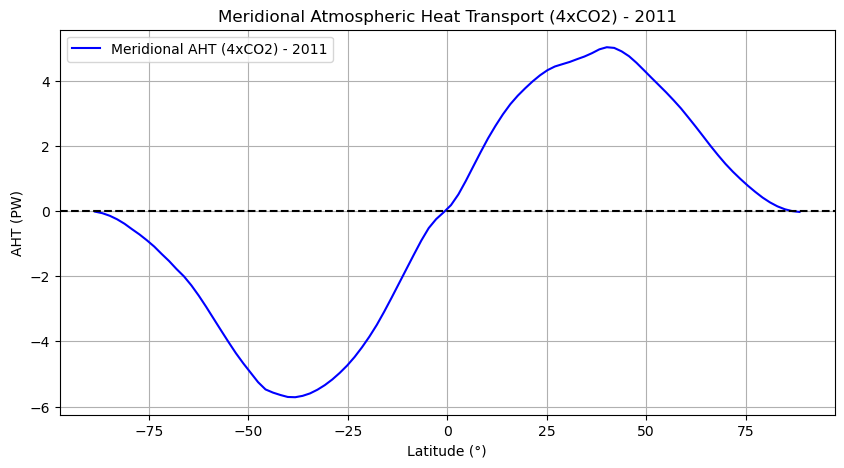

In [7]:
# Main execution
if __name__ == "__main__":
    year_to_analyze = 2011
    aht = calculate_aht(year_to_analyze)
    
    # Calculate meridional transport
    with nc.Dataset(files["ta"], mode="r") as ds:
        latitudes = ds.variables["lat"][:]
    
    aht_meridional = compute_meridional_transport(aht, latitudes)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(latitudes, aht_meridional, label=f"Meridional AHT (4xCO2) - {year_to_analyze}", color='b')
    plt.axhline(0, color="black", linestyle="--")
    plt.xlabel("Latitude (°)")
    plt.ylabel("AHT (PW)")
    plt.title(f"Meridional Atmospheric Heat Transport (4xCO2) - {year_to_analyze}")
    plt.legend()
    plt.grid()
    plt.show()

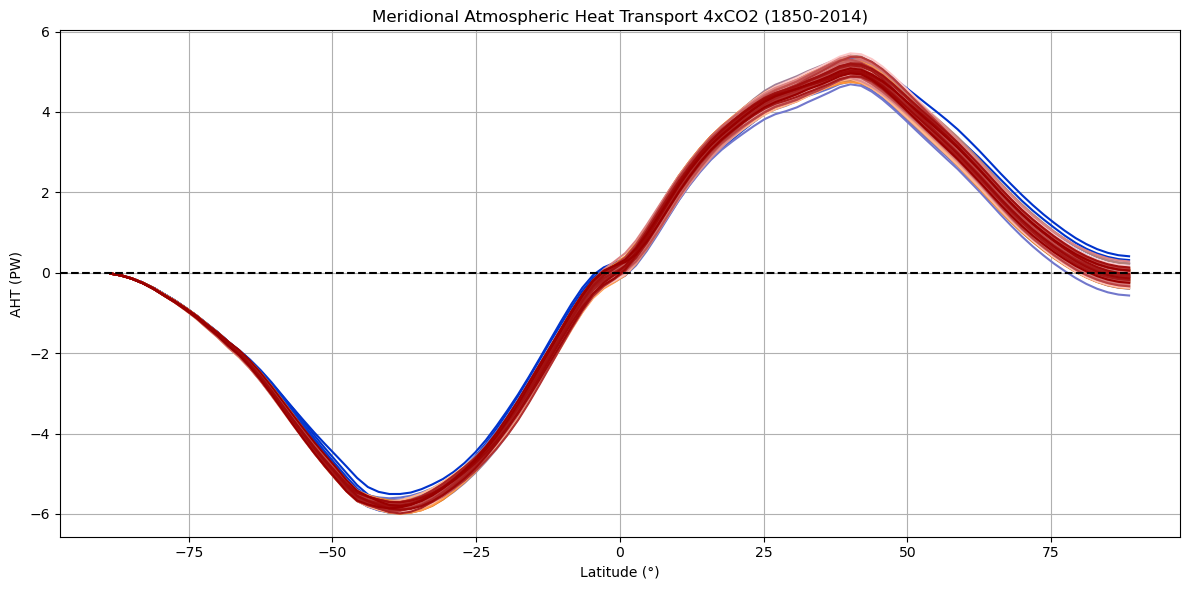

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Main execution
if __name__ == "__main__":
    # Loop through years from 1850 to 2014
    years_to_analyze = range(1850, 2015)
    
    # Initialize a dictionary to store AHT results for each year
    aht_meridional_all_years_4xco2 = {}
    
    # Define a custom colormap from light red to orange to dark red
    colors = [(0, 0.2, 0.8), (0.5, 0.5, 0.8), (1, 0.5, 0), (1, 0.8, 0.8), (0.6, 0, 0)]  # Red to orange to dark red
    n_bins = 100  # Discretize the colormap into 100 bins
    cmap_name = 'red_orange'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    # Normalize year range for color mapping
    norm = plt.Normalize(vmin=min(years_to_analyze), vmax=max(years_to_analyze))
    
    # Loop through all available years and compute AHT
    for year in years_to_analyze:
        try:
            aht = calculate_aht(year)
        
            # Get the latitudes for meridional transport
            with nc.Dataset(files["ta"], mode="r") as ds:
                latitudes = ds.variables["lat"][:]
        
            # Compute meridional heat transport
            aht_meridional = compute_meridional_transport(aht, latitudes)
        
            # Store the result for plotting
            aht_meridional_all_years_4xco2[year] = aht_meridional
        except ValueError as e:
            print(f"Skipping year {year}: {e}")
            continue
    
    # Plotting all years' results
    plt.figure(figsize=(12, 6))
    
    # Set up the custom colormap based on the years
    for idx, (year, aht_meridional) in enumerate(aht_meridional_all_years_4xco2.items()):
        plt.plot(latitudes, aht_meridional, color=custom_cmap(norm(year)))
    
    # Add a horizontal line at 0
    plt.axhline(0, color="black", linestyle="--")
    
    # Customize labels, title, and grid
    plt.xlabel("Latitude (°)")
    plt.ylabel("AHT (PW)")
    plt.title("Meridional Atmospheric Heat Transport 4xCO2 (1850-2014)")
    
    # Add gridlines for better readability
    plt.grid(True)
    
    # Adjust layout to ensure everything fits
    plt.tight_layout()
    
    # Show the plot
    plt.show()

#  pi control

In [9]:
# File Paths 
files = {
    "ta": " ta_Amon_ MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc",
    "hus": " specific_humidity_ MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc",
    "zg": " zg_Amon_ MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc ",
    "toa_sw_down": " toa_incoming_shortwave_flux_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc",  # rsdt
    "toa_sw_up": " toa_outgoing_shortwave_flux_ MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc",  # rsut
    "surf_sw_down": " surface_downwelling_shortwave_flux_in_air_ MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc",  # rsds
    "surf_sw_up": " surface_upwelling_shortwave_flux_in_air_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc ",  # rsus
    "toa_lw_up": " toa_outgoing_longwave_flux_ MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc",  # rlut
    "surf_lw_up": " surface_upwelling_longwave_flux_in_air_ MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc",  # rlus
    "surf_lw_down": " surface_downwelling_longwave_flux_in_air_ MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc",  # rlds
    "sensible": " surface_upward_sensible_heat_flux_ MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc",  # hfss
    "latent": " surface_upward_latent_heat_flux_ MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_1850-2849.nc"  # hfls

}
def load_nc_variable(filename, var_name, year):
    """Loads a variable from NetCDF file for a specific year."""
    ds = nc.Dataset(filename, mode="r")
    time_var = ds.variables["time"]
    time_units = time_var.units
    time_values = num2date(time_var[:], units=time_units)
    year_indices = [i for i, t in enumerate(time_values) if t.year == year]
    
    if not year_indices:
        raise ValueError(f"No data found for year {year}")
    
    var = ds.variables[var_name][year_indices, ...] if var_name in ds.variables else None
    if var is None:
        raise ValueError(f"Variable {var_name} not found in {filename}")
        
    ds.close()
    return var

In [10]:
def compute_storage_term(T, q, pressure_levels):
    """Computes the vertically integrated atmospheric storage term."""
    cp = 1005  # J/kgK
    Lv = 2.5e6  # J/kg
    g = 9.81  # m/s²
    
    dse = cp * T + Lv * q
    
    # Time derivative (assuming monthly data)
    dt = 30 * 24 * 3600  # seconds in a month (approximate)
    storage_term = np.gradient(dse, dt, axis=0)
    
    # Vertical integration (pressure integral)
    dp = -np.gradient(pressure_levels)  # Negative because pressure decreases with height
    storage_term_integrated = np.trapz(storage_term / g, x=pressure_levels, axis=1)
    
    return storage_term_integrated

def compute_meridional_transport(aht, latitudes):
    """Computes meridional heat transport in Petawatts (PW)."""
    R_earth = 6.371e6  # Earth radius in meters
    lat_radians = np.deg2rad(latitudes)
    dlat = np.gradient(lat_radians)
    cos_lat = np.cos(lat_radians)
    
    # Zonal and time mean
    aht_zonal_mean = np.mean(aht, axis=(0, -1))
    
    # Meridional integration from South to North
    transport = 2 * np.pi * R_earth**2 * np.cumsum(aht_zonal_mean * cos_lat * dlat)
    
    # Convert to Petawatts
    transport_PW = transport * 1e-15
    
    return transport_PW

def calculate_aht(year_to_analyze):
    """Main function to calculate atmospheric heat transport."""
    # Load required variables
    toa_sw_down = load_nc_variable(files["toa_sw_down"], "rsdt", year_to_analyze)
    toa_sw_up = load_nc_variable(files["toa_sw_up"], "rsut", year_to_analyze)  # rsut
    surf_sw_down = load_nc_variable(files["surf_sw_down"], "rsds", year_to_analyze)  # rsds
    surf_sw_up = load_nc_variable(files["surf_sw_up"], "rsus", year_to_analyze)  # rsus
    toa_lw_up = load_nc_variable(files["toa_lw_up"], "rlut", year_to_analyze)  # rlut
    surf_lw_up = load_nc_variable(files["surf_lw_up"], "rlus", year_to_analyze)  # rlus
    surf_lw_down = load_nc_variable(files["surf_lw_down"], "rlds", year_to_analyze)  # rlds
    sensible = load_nc_variable(files["sensible"], "hfss", year_to_analyze)  # hfss
    latent = load_nc_variable(files["latent"], "hfls", year_to_analyze)  # hfls
    
    # Energy components
    sw_absorbed = (toa_sw_down - toa_sw_up) - (surf_sw_down - surf_sw_up)
    shf = sensible + latent + (surf_lw_up - surf_lw_down)
    
    # Storage term
    T = load_nc_variable(files["ta"], "ta", year_to_analyze)
    q = load_nc_variable(files["hus"], "hus", year_to_analyze)
    
    with nc.Dataset(files["ta"], mode="r") as ds_atm:
        pressure_levels = ds_atm.variables["plev"][:]
        
    storage_term = compute_storage_term(T, q, pressure_levels)
    
    # Final AHT calculation
    aht = sw_absorbed - toa_lw_up + shf - storage_term
    
    return aht

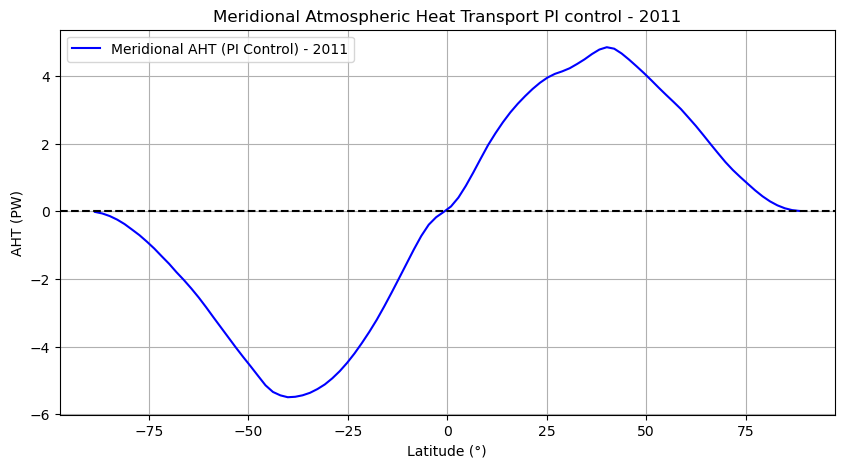

In [11]:
# Main execution
if __name__ == "__main__":
    year_to_analyze = 2011
    aht = calculate_aht(year_to_analyze)
    
    # Calculate meridional transport
    with nc.Dataset(files["ta"], mode="r") as ds:
        latitudes = ds.variables["lat"][:]
    
    aht_meridional = compute_meridional_transport(aht, latitudes)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(latitudes, aht_meridional, label=f"Meridional AHT (PI Control) - {year_to_analyze}", color='b')
    plt.axhline(0, color="black", linestyle="--")
    plt.xlabel("Latitude (°)")
    plt.ylabel("AHT (PW)")
    plt.title(f"Meridional Atmospheric Heat Transport PI control - {year_to_analyze}")
    plt.legend()
    plt.grid()
    plt.show()

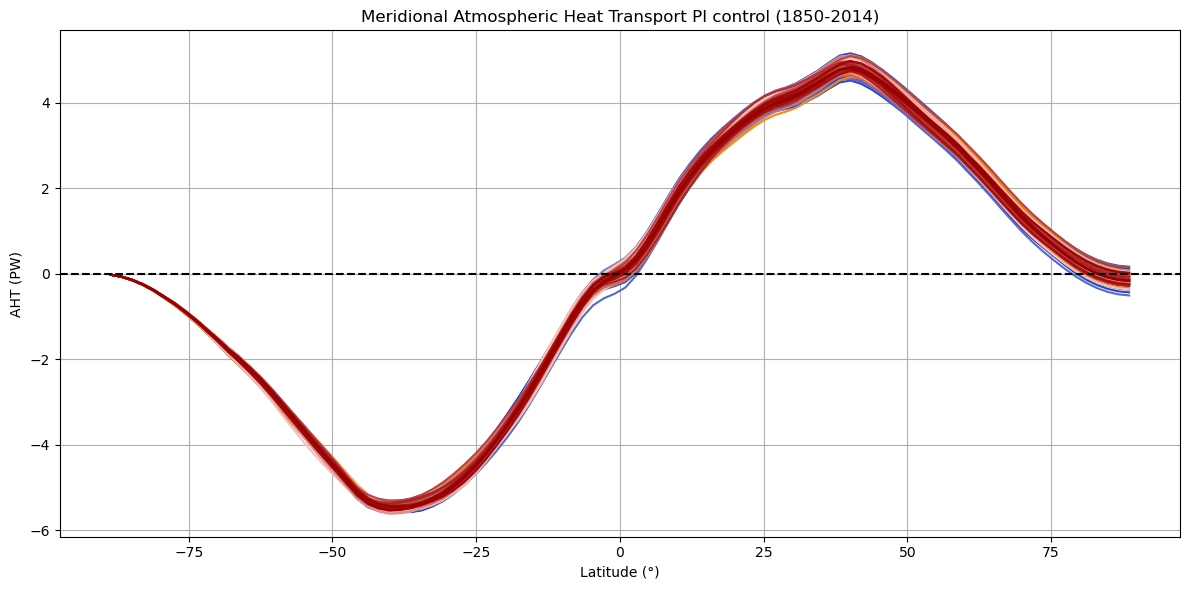

In [12]:
# Main execution
if __name__ == "__main__":
    # Loop through years from 1850 to 2014
    years_to_analyze = range(1850, 2015)
    
    # Initialize a dictionary to store AHT results for each year
    aht_meridional_all_years_picontrol = {}
    
    # Define a custom colormap from light red to orange to dark red
    colors = [(0, 0.2, 0.8), (0.5, 0.5, 0.8), (1, 0.5, 0), (1, 0.8, 0.8), (0.6, 0, 0)] 
    n_bins = 100  # Discretize the colormap into 100 bins
    cmap_name = 'red_orange'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    # Normalize year range for color mapping
    norm = plt.Normalize(vmin=min(years_to_analyze), vmax=max(years_to_analyze))
    
    # Loop through all available years and compute AHT
    for year in years_to_analyze:
        try:
            aht = calculate_aht(year)
        
            # Get the latitudes for meridional transport
            with nc.Dataset(files["ta"], mode="r") as ds:
                latitudes = ds.variables["lat"][:]
        
            # Compute meridional heat transport
            aht_meridional = compute_meridional_transport(aht, latitudes)
        
            # Store the result for plotting
            aht_meridional_all_years_picontrol[year] = aht_meridional
        except ValueError as e:
            print(f"Skipping year {year}: {e}")
            continue
    
    # Plotting all years' results
    plt.figure(figsize=(12, 6))
    
    # Set up the custom colormap based on the years
    for idx, (year, aht_meridional) in enumerate(aht_meridional_all_years_picontrol.items()):
        plt.plot(latitudes, aht_meridional, color=custom_cmap(norm(year)))
    
    # Add a horizontal line at 0
    plt.axhline(0, color="black", linestyle="--")
    
    # Customize labels, title, and grid
    plt.xlabel("Latitude (°)")
    plt.ylabel("AHT (PW)")
    plt.title("Meridional Atmospheric Heat Transport PI control (1850-2014)")
    
    # Add gridlines for better readability
    plt.grid(True)
    
    # Adjust layout to ensure everything fits
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# gifs

## 4x CO2

In [20]:
# Set the backend to Agg for non-interactive plotting (better for generating image files)
matplotlib.use('Agg')

# Main execution
if __name__ == "__main__":
    # Create a directory to store the temporary images
    output_dir = "aht_animation_frames"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Loop through years from 1850 to 2014
    years_to_analyze = range(1850, 2015)
    
    # Initialize a dictionary to store AHT results for each year
    aht_meridional_all_years = {}
    
    # Define a custom colormap from blue to red
    colors = [(0, 0.2, 0.8), (0.5, 0.5, 0.8), (0.8, 0.4, 0.4), (0.8, 0, 0)]  # Blue to light blue to light red to red
    n_bins = 100  # Discretize the colormap into 100 bins
    cmap_name = 'blue_to_red'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    # Normalize year range for color mapping
    norm = plt.Normalize(vmin=min(years_to_analyze), vmax=max(years_to_analyze))
    
    # Loop through all available years and compute AHT
    for year in years_to_analyze:
        try:
            aht = calculate_aht(year)
        
            # Get the latitudes for meridional transport
            with nc.Dataset(files["ta"], mode="r") as ds:
                latitudes = ds.variables["lat"][:]
        
            # Compute meridional heat transport
            aht_meridional = compute_meridional_transport(aht, latitudes)
        
            # Store the result for plotting
            aht_meridional_all_years_4xco2[year] = aht_meridional
        except ValueError as e:
            print(f"Skipping year {year}: {e}")
            continue
    
    # Find global min and max values for consistent y-axis across all frames
    all_values = np.concatenate([values for values in aht_meridional_all_years_4xco2.values()])
    y_min, y_max = np.min(all_values), np.max(all_values)
    y_margin = (y_max - y_min) * 0.1  # Add 10% margin
    
    # Create frames for the GIF
    frame_filenames = []
    
    # Sort years for ordered progression
    sorted_years = sorted(aht_meridional_all_years_4xco2.keys())
    
    
    # Generate frames
    for year in sorted_years:
        print(f"Processing frame for year {year}")
        plt.figure(figsize=(12, 6))
        
        # Plot historical data with lower opacity
        for past_year in sorted_years:
            if past_year < year:
                plt.plot(latitudes, aht_meridional_all_years_4xco2[past_year], 
                         alpha=0.15, color=custom_cmap(norm(past_year)))
        
        # Plot current year with full opacity
        plt.plot(latitudes, aht_meridional_all_years_4xco2[year], 
                 linewidth=2.5, color=custom_cmap(norm(year)))
        
        # Add a horizontal line at 0
        plt.axhline(0, color="black", linestyle="--")
        
        # Customize labels, title, and grid
        plt.xlabel("Latitude (°)")
        plt.ylabel("AHT (PW)")
        plt.title(f"Meridional Atmospheric Heat Transport 4xCO2 (Year: {year})")
        
        # Set consistent y-axis limits
        plt.ylim(y_min - y_margin, y_max + y_margin)
        
        # Add a colorbar to show the year progression
        sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.set_label('Year')
        
        # Add gridlines for better readability
        plt.grid(True)
        
        # Adjust layout to ensure everything fits
        plt.tight_layout()
        
        # Save the frame to a file
        frame_filename = os.path.join(output_dir, f"aht_frame_{year}.png")
        plt.savefig(frame_filename, dpi=100)
        frame_filenames.append(frame_filename)
        
        # Close the figure to free memory
        plt.close()
    
    # Create the GIF using imageio
    print("Creating GIF animation...")
    with imageio.get_writer('aht_animation_4xco2.gif', mode='I', duration=0.2) as writer:
        for filename in frame_filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    print(f"Animation saved as aht_animation_4xco2.gif")

Processing frame for year 1850


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

## pi control

In [ ]:
# Set the backend to Agg for non-interactive plotting (better for generating image files)
matplotlib.use('Agg')

# Main execution
if __name__ == "__main__":
    # Create a directory to store the temporary images
    output_dir = "aht_animation_frames"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Loop through years from 1850 to 2014
    years_to_analyze = range(1850, 2015)
    
    # Initialize a dictionary to store AHT results for each year
    aht_meridional_all_years_picontrol = {}
    
    # Define a custom colormap from blue to red
    colors = [(0, 0.2, 0.8), (0.5, 0.5, 0.8), (0.8, 0.4, 0.4), (0.8, 0, 0)]  # Blue to light blue to light red to red
    n_bins = 100  # Discretize the colormap into 100 bins
    cmap_name = 'blue_to_red'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    # Normalize year range for color mapping
    norm = plt.Normalize(vmin=min(years_to_analyze), vmax=max(years_to_analyze))
    
    # Loop through all available years and compute AHT
    for year in years_to_analyze:
        try:
            aht = calculate_aht(year)
        
            # Get the latitudes for meridional transport
            with nc.Dataset(files["ta"], mode="r") as ds:
                latitudes = ds.variables["lat"][:]
        
            # Compute meridional heat transport
            aht_meridional = compute_meridional_transport(aht, latitudes)
        
            # Store the result for plotting
            aht_meridional_all_years_picontrol[year] = aht_meridional
        except ValueError as e:
            print(f"Skipping year {year}: {e}")
            continue
    
    # Find global min and max values for consistent y-axis across all frames
    all_values = np.concatenate([values for values in aht_meridional_all_years_picontrol.values()])
    y_min, y_max = np.min(all_values), np.max(all_values)
    y_margin = (y_max - y_min) * 0.1  # Add 10% margin
    
    # Create frames for the GIF
    frame_filenames = []
    
    # Sort years for ordered progression
    sorted_years = sorted(aht_meridional_all_years_picontrol.keys())
    
    
    # Generate frames
    for year in sorted_years:
        print(f"Processing frame for year {year}")
        plt.figure(figsize=(12, 6))
        
        # Plot historical data with lower opacity
        for past_year in sorted_years:
            if past_year < year:
                plt.plot(latitudes, aht_meridional_all_years_picontrol[past_year], 
                         alpha=0.15, color=custom_cmap(norm(past_year)))
        
        # Plot current year with full opacity
        plt.plot(latitudes, aht_meridional_all_years_picontrol[year], 
                 linewidth=2.5, color=custom_cmap(norm(year)))
        
        # Add a horizontal line at 0
        plt.axhline(0, color="black", linestyle="--")
        
        # Customize labels, title, and grid
        plt.xlabel("Latitude (°)")
        plt.ylabel("AHT (PW)")
        plt.title(f"Meridional Atmospheric Heat Transport PI Control (Year: {year})")
        
        # Set consistent y-axis limits
        plt.ylim(y_min - y_margin, y_max + y_margin)
        
        # Add a colorbar to show the year progression
        sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.set_label('Year')
        
        # Add gridlines for better readability
        plt.grid(True)
        
        # Adjust layout to ensure everything fits
        plt.tight_layout()
        
        # Save the frame to a file
        frame_filename = os.path.join(output_dir, f"aht_frame_{year}.png")
        plt.savefig(frame_filename, dpi=100)
        frame_filenames.append(frame_filename)
        
        # Close the figure to free memory
        plt.close()
    
    # Create the GIF using imageio
    print("Creating GIF animation...")
    with imageio.get_writer('aht_animation_picontrol.gif', mode='I', duration=0.2) as writer:
        for filename in frame_filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    print(f"Animation saved as aht_animation_picontrol.gif")

# combined plot

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from matplotlib.lines import Line2D

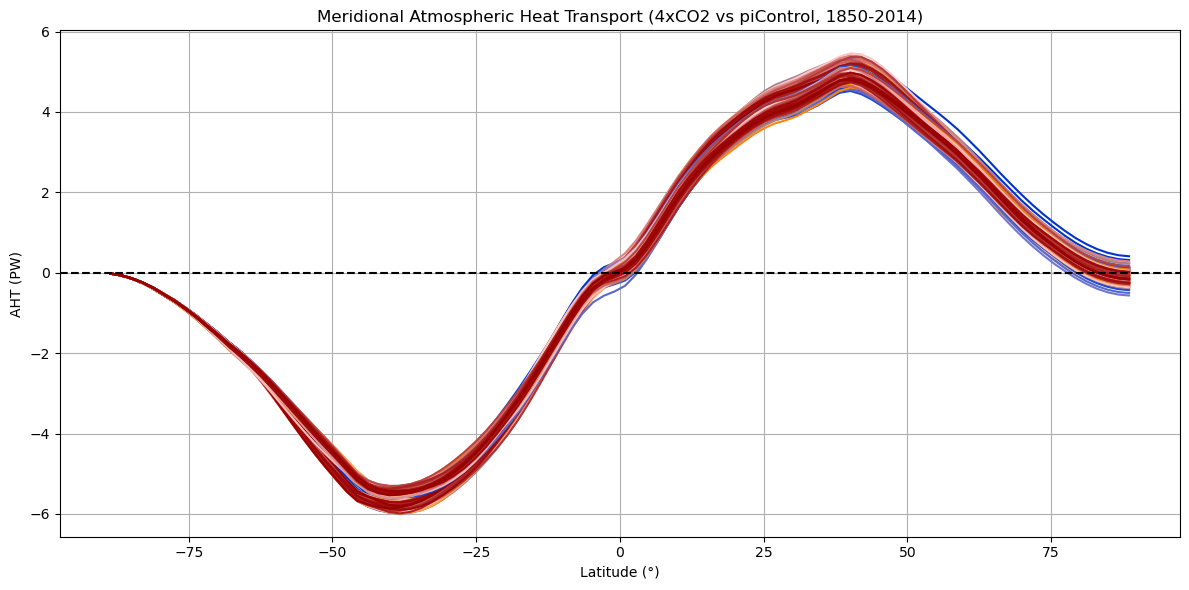

In [14]:
# Set up years to analyze
years_to_analyze = range(1850, 2015)

# Plotting both 4xCO2 and piControl results
plt.figure(figsize=(12, 6))

# Custom colormap for years (same one for both plots)
colors = [(0, 0.2, 0.8), (0.5, 0.5, 0.8), (1, 0.5, 0), (1, 0.8, 0.8), (0.6, 0, 0)] 
n_bins = 100  # Discretize the colormap into 100 bins
cmap_name = 'red_orange'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = plt.Normalize(vmin=min(years_to_analyze), vmax=max(years_to_analyze))

# Plot for 4xCO2 - Loop over the years and plot the AHT meridional for each year
for idx, year in enumerate(years_to_analyze):
    try:
        aht_meridional_4xco2 = aht_meridional_all_years_4xco2[year]  # Replace with your actual variable
        plt.plot(latitudes, aht_meridional_4xco2, color=custom_cmap(norm(year)), label=f"4xCO2 - {year}" if idx == 0 else "")
    except KeyError:
        continue  # Skip if year data is not available

# Plot for piControl - Loop over the years and plot the AHT meridional for each year
for idx, year in enumerate(years_to_analyze):
    try:
        aht_meridional_picontrol = aht_meridional_all_years_picontrol[year]  # Replace with your actual variable
        plt.plot(latitudes, aht_meridional_picontrol, color=custom_cmap(norm(year)), label=f"piControl - {year}" if idx == 0 else "")
    except KeyError:
        continue  # Skip if year data is not available

# Add a horizontal line at 0
plt.axhline(0, color="black", linestyle="--")

# Customize labels, title, and grid
plt.xlabel("Latitude (°)")
plt.ylabel("AHT (PW)")
plt.title("Meridional Atmospheric Heat Transport (4xCO2 vs piControl, 1850-2014)")

# Add gridlines for better readability
plt.grid(True)

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

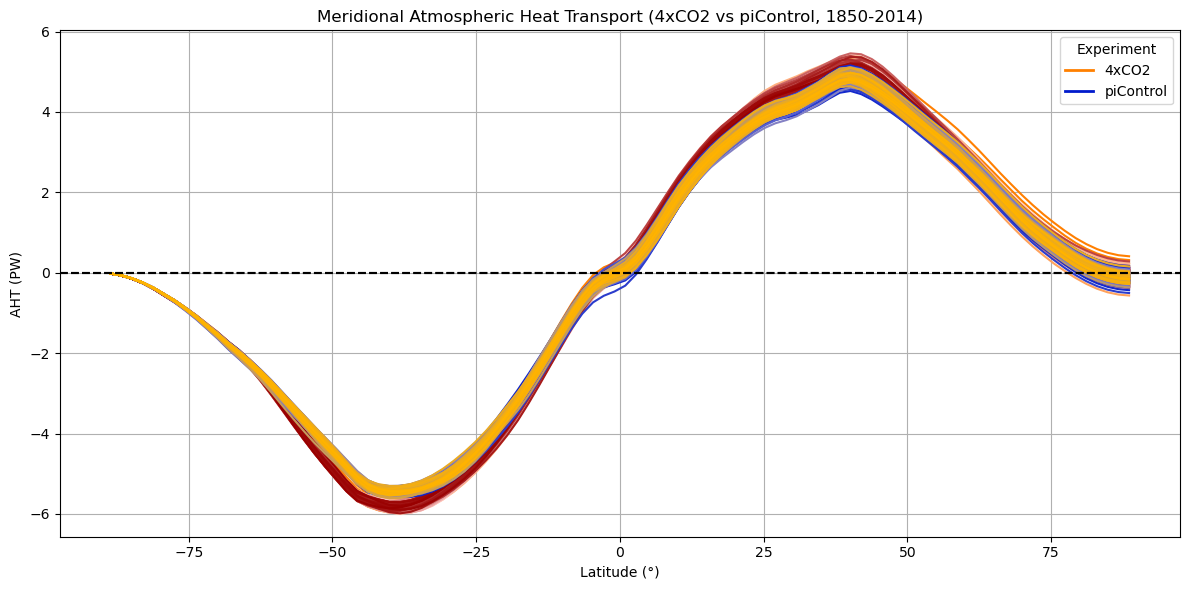

In [19]:
# Set up years to analyze
years_to_analyze = range(1850, 2015)

# Plotting both 4xCO2 and piControl results
plt.figure(figsize=(12, 6))

# Custom colormap for 4xCO2 (Red-Orange)
colors_4xco2 = [(1, 0.5, 0), (1, 0.8, 0.8), (0.6, 0, 0)] 
n_bins = 500  # Discretize the colormap 
cmap_4xco2 = LinearSegmentedColormap.from_list('red_orange', colors_4xco2, N=n_bins)

# Custom colormap for piControl (Blue-Gradient)
colors_picontrol = [(0, 0.1, 0.8), (0.5, 0.5, 0.8), (1, 0.7, 0)] 
n_bins = 500  # Discretize the colormap 
cmap_picontrol = LinearSegmentedColormap.from_list('blue_gradient', colors_picontrol, N=n_bins)

# Normalize the years
norm = plt.Normalize(vmin=min(years_to_analyze), vmax=max(years_to_analyze))

# Plot for 4xCO2 - Loop over the years and plot the AHT meridional for each year
for idx, year in enumerate(years_to_analyze):
    try:
        aht_meridional_4xco2 = aht_meridional_all_years_4xco2[year]  # Replace with your actual variable
        plt.plot(latitudes, aht_meridional_4xco2, color=cmap_4xco2(norm(year)), label=f"4xCO2 - {year}" if idx == 0 else "")
    except KeyError:
        continue  # Skip if year data is not available

# Plot for piControl - Loop over the years and plot the AHT meridional for each year
for idx, year in enumerate(years_to_analyze):
    try:
        aht_meridional_picontrol = aht_meridional_all_years_picontrol[year]  # Replace with your actual variable
        plt.plot(latitudes, aht_meridional_picontrol, color=cmap_picontrol(norm(year)), label=f"piControl - {year}" if idx == 0 else "")
    except KeyError:
        continue  # Skip if year data is not available

# Add a horizontal line at 0
plt.axhline(0, color="black", linestyle="--")

# Create custom legend handles
legend_handles = [
    Line2D([0], [0], color=cmap_4xco2(norm(min(years_to_analyze))), lw=2, label="4xCO2"),
    Line2D([0], [0], color=cmap_picontrol(norm(min(years_to_analyze))), lw=2, label="piControl")
]

# Customize labels, title, and grid
plt.xlabel("Latitude (°)")
plt.ylabel("AHT (PW)")
plt.title("Meridional Atmospheric Heat Transport (4xCO2 vs piControl, 1850-2014)")

# Add a horizontal line at 0
plt.axhline(0, color="black", linestyle="--")

# Add gridlines for better readability
plt.grid(True)

# Add the legend
plt.legend(handles=legend_handles, title="Experiment", loc="upper right")

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


In [16]:
# Set the backend to Agg for non-interactive plotting (better for generating image files)
matplotlib.use('Agg')

# Main execution
if __name__ == "__main__":
    # Create a directory to store the temporary images
    output_dir = "aht_anomaly_frames"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Loop through years from 1850 to 2014
    years_to_analyze = range(1850, 2015)
    
    # Define base period
    base_period_start = 1850
    base_period_end = 1900
    base_period = range(base_period_start, base_period_end + 1)
    
    # Initialize a dictionary to store AHT results for each year
    aht_meridional_all_years = {}
    
    # Define a custom colormap from blue to red
    colors = [(0, 0.2, 0.8), (0.5, 0.5, 0.8), (0.8, 0.4, 0.4), (0.8, 0, 0)]  # Blue to light blue to light red to red
    n_bins = 100  # Discretize the colormap into 100 bins
    cmap_name = 'blue_to_red'
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    # Normalize year range for color mapping
    norm = plt.Normalize(vmin=min(years_to_analyze), vmax=max(years_to_analyze))
    
    # Loop through all available years and compute AHT
    for year in years_to_analyze:
        try:
            aht = calculate_aht(year)
        
            # Get the latitudes for meridional transport
            with nc.Dataset(files["ta"], mode="r") as ds:
                latitudes = ds.variables["lat"][:]
        
            # Compute meridional heat transport
            aht_meridional = compute_meridional_transport(aht, latitudes)
        
            # Store the result for plotting
            aht_meridional_all_years[year] = aht_meridional
        except ValueError as e:
            print(f"Skipping year {year}: {e}")
            continue
    
    # Calculate the base period average
    base_period_values = []
    for year in base_period:
        if year in aht_meridional_all_years:
            base_period_values.append(aht_meridional_all_years[year])
    
    if not base_period_values:
        raise ValueError("No data available for the base period")
    
    # Calculate mean across all base period years
    base_period_mean = np.mean(base_period_values, axis=0)
    
    # Calculate anomalies by subtracting base period mean
    aht_anomalies = {}
    for year, values in aht_meridional_all_years.items():
        aht_anomalies[year] = values - base_period_mean
    
    # Find global min and max values for consistent y-axis across all frames
    all_anomaly_values = np.concatenate([values for values in aht_anomalies.values()])
    y_min, y_max = np.min(all_anomaly_values), np.max(all_anomaly_values)
    y_margin = max(abs(y_min), abs(y_max)) * 0.1  # Add 10% margin
    y_limit = max(abs(y_min), abs(y_max)) + y_margin  # Symmetric y-axis limits
    
    # Create frames for the GIF
    frame_filenames = []
    
    # Sort years for ordered progression
    sorted_years = sorted(aht_anomalies.keys())
    
    # Generate frames
    for year in sorted_years:
        print(f"Processing frame for year {year}")
        plt.figure(figsize=(12, 6))
        
        # Plot historical data with lower opacity
        for past_year in sorted_years:
            if past_year < year:
                plt.plot(latitudes, aht_anomalies[past_year], 
                         alpha=0.15, color=custom_cmap(norm(past_year)))
        
        # Plot current year with full opacity
        plt.plot(latitudes, aht_anomalies[year], 
                 linewidth=2.5, color=custom_cmap(norm(year)))
        
        # Add a horizontal line at 0
        plt.axhline(0, color="black", linestyle="--")
        
        # Customize labels, title, and grid
        plt.xlabel("Latitude (°)")
        plt.ylabel("AHT Anomaly (PW)")
        plt.title(f"Meridional Atmospheric Heat Transport Anomaly\n(Base Period: {base_period_start}-{base_period_end}, Year: {year})")
        
        # Set consistent and symmetric y-axis limits
        plt.ylim(-y_limit, y_limit)
        
        # Add a colorbar to show the year progression
        # Try this instead:  
        fig = plt.gcf()  # Get current figure
        ax = plt.gca()   # Get current axes
        sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)  # Specify which axes to use
        cbar.set_label('Year')


        
        # Add gridlines for better readability
        plt.grid(True)
        
        # Adjust layout to ensure everything fits
        plt.tight_layout()
        
        # Save the frame to a file
        frame_filename = os.path.join(output_dir, f"aht_anomaly_frame_{year}.png")
        plt.savefig(frame_filename, dpi=100)
        frame_filenames.append(frame_filename)
        
        # Close the figure to free memory
        plt.close()
    
    # Create the GIF using imageio
    print("Creating GIF animation...")
    with imageio.get_writer('aht_anomaly_animation.gif', mode='I', duration=0.6) as writer:
        for filename in frame_filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    print(f"Animation saved as aht_anomaly_animation.gif")

Processing frame for year 1850
Processing frame for year 1851
Processing frame for year 1852
Processing frame for year 1853
Processing frame for year 1854
Processing frame for year 1855
Processing frame for year 1856
Processing frame for year 1857
Processing frame for year 1858
Processing frame for year 1859
Processing frame for year 1860
Processing frame for year 1861
Processing frame for year 1862
Processing frame for year 1863
Processing frame for year 1864
Processing frame for year 1865
Processing frame for year 1866
Processing frame for year 1867
Processing frame for year 1868
Processing frame for year 1869
Processing frame for year 1870
Processing frame for year 1871
Processing frame for year 1872
Processing frame for year 1873
Processing frame for year 1874
Processing frame for year 1875
Processing frame for year 1876
Processing frame for year 1877
Processing frame for year 1878
Processing frame for year 1879
Processing frame for year 1880
Processing frame for year 1881
Processi

C:\Users\DELL\AppData\Local\Temp\ipykernel_21948\3261945691.py:133: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Animation saved as aht_anomaly_animation.gif
